In [2]:
import os 
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(42)

## Custom Datasets

In [3]:
class MyDataset(Dataset):
    def __init__(self, path, transformations=None):
        #Apply img transformations
        self.transformations = transformations
        #Load all images in a path
        self.img_paths = [im_path for im_path in sorted(glob(f"{path}/*/*"))]
        #Dictionaries and counters for classes and count per class
        self.class_names = {}
        self.class_counts = {}
        count = 0

        for idx, img_path in enumerate(self.img_paths):
            #Get the class name
            class_name = self.get_class(img_path)
            #Check if the class exist already and if not appends it to the class name dict
            if class_name not in self.class_names:
                self.class_names[class_name] = count
                self.class_counts[class_name] = 1
                count += 1
            #If it exist, increase the counter for that class
            else:
                self.class_counts[class_name] += 1

    #Function to get the real label of an img
    def get_class(self, path) -> str:
        """Return the name of the class based on its path"""
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self):
        return len(self.img_paths)
    
    #Obtain 1 image and its label from te ds
    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_names[self.get_class(img_path)]

        #If there are tarnsformation, apply it to return the image with them.
        if self.transformations is not None:
            image = self.transformations(image)
        return image, label
        


## Dataloaders

In [4]:
from torch.utils.data import Subset
torch.manual_seed(42)

def create_dataloaders_random(path, transformations, batch_size, split: list = [0.9, 0.05, 0.05], num_workers: int = 4):
    """Organize and create the dataloaders for train, valid and test using our datset objet. The split is RANDOM! """
    dataset = MyDataset(path = path, transformations=transformations)
    #Calculate the len for each split (train, valid, test)
    dataset_len = len(dataset)
    train_len = int(dataset_len * split[0])
    val_len = int(dataset_len * split[1])
    test_len = int(dataset_len * split[2])

    #Create the splits 
    tr_ds, val_ds, test_ds = random_split(dataset, lengths=[train_len, val_len, test_len])

    #Create the dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers) 
    #Avoid shuffle for replicability in both val and test 
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    #test images are evaluated 1 by 1  
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)  

    #Return dataloaders for each split andthe class_names with its IDs (keys are the name, value the ID)
    return tr_dl, val_dl, test_dl, dataset.class_names


def stratified_dataset_split(dataset: Dataset, split: list = [0.9, 0.05, 0.05]):
    """Create the stratified subsets. Mantain class proportions """
    #We want to create a dictionary of image indexes for each class
    class_idxs = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_idxs:
            class_idxs[label] = []
        class_idxs[label].append(idx)

    #Create the splits for each clas
    train_idxs, val_idxs, test_idxs = [], [], []
    for label, idxs in class_idxs.items():
        n_total = len(idxs)
        n_train = int(n_total * split[0])
        n_val = int(n_total * split[1])
        n_test = int(n_total * split[2])

        #Divide the indexes (idxs is a list of indexes) of each class in our list of indexes per split
        train_idxs.extend(idxs[:n_train])
        val_idxs.extend(idxs[n_train:n_train + n_val])
        test_idxs.extend(idxs[n_train + n_val:n_train + n_val + n_test])

    #Create the subsets using torch utils Subset
    tr_ds = Subset(dataset, train_idxs)
    val_ds = Subset(dataset, val_idxs)
    test_ds = Subset(dataset, test_idxs)

    return tr_ds, val_ds, test_ds

    


def create_stratified_dataloaders(path, transformations, batch_size, split: list = [0.9, 0.05, 0.05], num_workers: int = 4):
    dataset = MyDataset(path=path, transformations=transformations)

    #stratified_dataset_split will return subsets of datasets acording our factors
    tr_ds, val_ds, test_ds = stratified_dataset_split(dataset, split)

    #Create the stratified dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    #Typically test_dl shuffle is false, but in this case we will keep it true for the randomnes on inference visualization
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=True, num_workers=num_workers)

    #Return dataloaders and classes
    return tr_dl, val_dl, test_dl, dataset.class_names

## Initialization dataset and dataloaders for our project

In [5]:
ds_path = "dataset"

#Normalization parameters per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resize = 224

#Define the transformations using transforms utils
    #Resize to 224x224
    #Tranform to tensor
    #Normalize according typical values of ConvNext, ResNet and so
transforms = T.Compose([
    T.Resize((resize,resize)),
    T.ToTensor(),
    T.Normalize(mean = mean, std = std)]
)

#Create the dataloaders using our function
tr_dl, val_dl, test_dl, classes = create_stratified_dataloaders(path=ds_path, transformations=transforms, batch_size=32)


In [6]:
#Check the batches per dataloader
print(len(tr_dl)); print(len(val_dl)); print(len(test_dl)); print(classes)

225
13
400
{'Bridge': 0, 'Commercial': 1, 'Industrial': 2, 'Intersection': 3, 'Landmark': 4, 'Park': 5, 'Parking': 6, 'Playground': 7, 'Residential': 8, 'Stadium': 9}


The numbers are correct. We have 400 batches in the test_dl because we specified batch size of 1

## Data visualization

In [7]:
from matplotlib import pyplot as pt
import random

def tensor2image(tensor, img_type = "rgb"):
    #Tensor images in pytorch are expressed in [C x H x W]
    #We need to transform the tensors back to images
    gray_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.], std = [1/0.5]),
        #Then we invert the mean
        T.Normalize(mean = [-0.5], std = [1])
    ])

    rgb_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.,0.,0.], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        #Then we invert the mean (sum the mean, because is the opposite in the normalization, substract)
        T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
    ])

    invert_transforms = rgb_transforms if img_type.lower() == "rgb" else gray_transforms
    #invert_transform --> applies inverse transformations to the tensored image and multiply by 255 to get the px value
    #.detach() --> Disconnect the tensor from calculating gradients
    #.squeeze() --> Deletes dimensions with 1, for instance in gray images
    #.cpu() --> move the tensor to the CPU if it was located in the GPU
    #.permut(1,2,0) --> changes axes of the tesnor (C, H, W,) for the ones expected by matplotlib (H, W, C)
    #.numpy() --> converts the array to a numpy array
    #.astype(np.uint8) --> Converts the values to the 8bit format of images
    #The result  is a an image ready to be visualized by matplotlib (denormalized, H,W,C, 224x224)
    return (invert_transforms(tensor) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    
    #return (invert_transforms(tensor) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if img_type == "gray" else (invert_transforms(tensor) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)


def plot_images(dataset, n_imgs, rows, img_type: str = None, class_names = None):
    #Check if the input has a img_type otherwise rise an assertError
    assert img_type.lower() in ["rgb", "gray"], "Missing image type (rgb or gray)"
    #Select the color map for the type of image
    if img_type == "rgb":
        #If the images is RGB select viridis color map
        cmap = "viridis"
    else:
        cmap = img_type
    #Create the figure where the images will be displayed
    pt.figure(figsize=(20,10))
    #Create a list of random indexes of images from the dataset and input "n_imgs"
    rndm_idx = [random.randint(0, len(dataset) -1) for _ in range(n_imgs)]
    
    for i, idx in enumerate(rndm_idx):
        img_tensor, label = dataset[idx]
        #Create one image inside figure (1 position inside the grid)
        pt.subplot(rows, n_imgs // rows, i + 1)
        if img_type:
            pt.imshow(tensor2image(tensor=img_tensor, img_type=img_type), cmap=cmap)
        #If there is no type specified, use the default value which is "rgb"
        else:
            pt.imshow(tensor2image(tensor=img_tensor))
        pt.axis("off")
        if class_names is not None:
            #If class_name is defined, use it
            pt.title(f"True L --> {class_names[int(label)]}")
        else:
            #Else, use the true label
            pt.title(f"True L --> {label}")



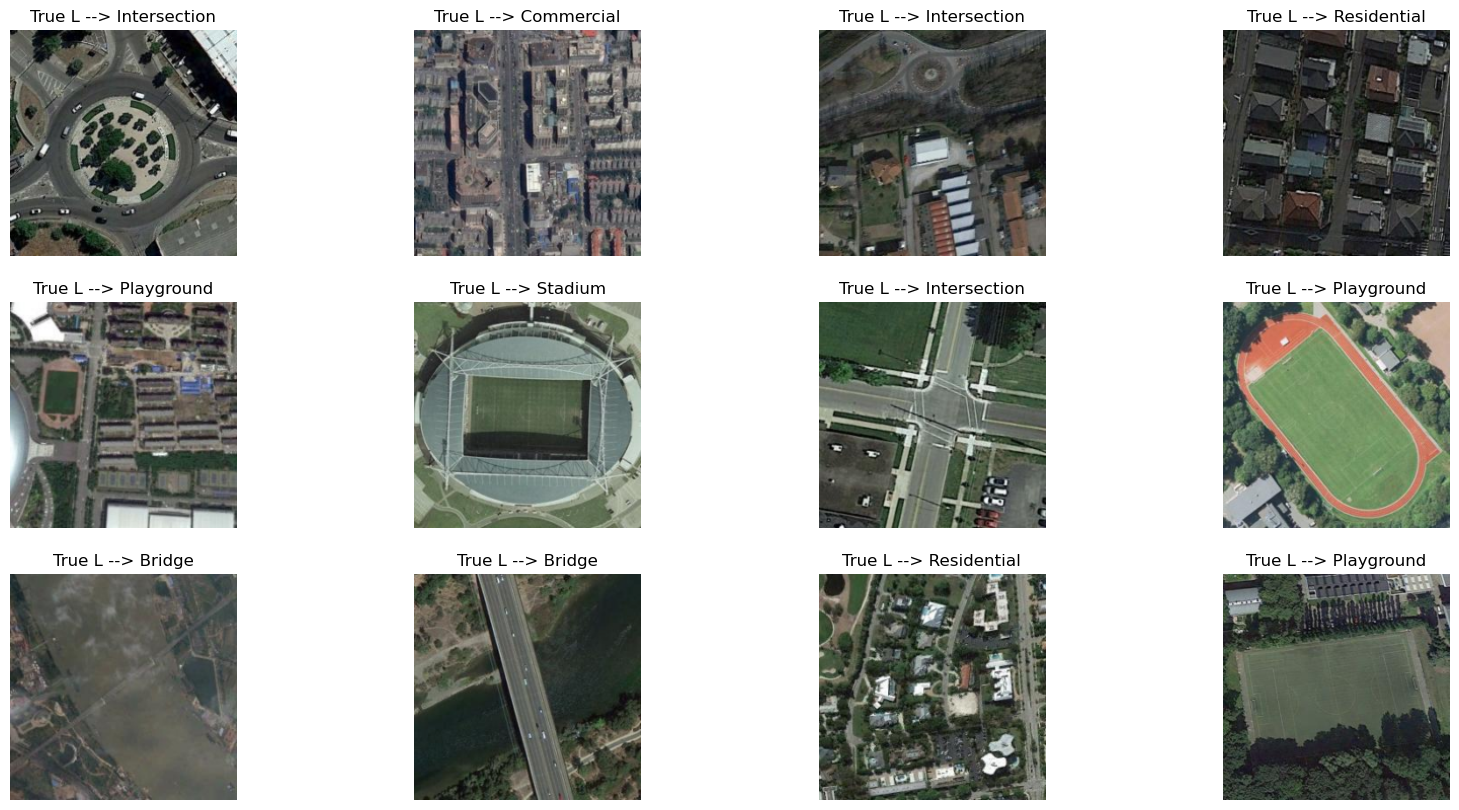

In [8]:
plot_images(tr_dl.dataset, 12, 3, "rgb", list(classes.keys()))

In [ ]:
plot_images(tr_dl.dataset, 12, 3, "rgb", list(classes.keys()))

## Simple EDA: Class distributions

In [9]:
def class_distribution(dataset_path: str, transformations: T.Compose):
    """ Func that, given a dataset and transformations, plots the distributions of the classes"""
    dataset = MyDataset(path=dataset_path, transformations=transformations)
    
    #Graphic parameters for text
    width = 0.8
    text_width = 0.06
    text_height = 2
    class_counts = dataset.class_counts
    class_names = list(dataset.class_names.keys())
    counts = list(class_counts.values())

    fig, ax = pt.subplots(figsize= (20,10))
    #Return evenly spaced values from a range, for the bar graph
    idxs = np.arange(len(counts))
    #Create the bars
    ax.bar(idxs, counts, width, color="blue")

    #Graphic config
    # Set axis X title
    ax.set_xlabel("Class names", color=("black"))
    # Set the ticks in axis X and its labels
    ax.set(xticks=idxs, xticklabels=class_names)
    # Set a parameter rotation for the axis X labels
    ax.tick_params(axis="x", rotation=45)
    #Set axis Y label
    ax.set_ylabel("Frequency", color="black")
    #Set title for the graph
    ax.set_title("Classes distribution")
    
    #Adds a text over each column
    for i, val in enumerate(counts):
        ax.text(i - text_width, val + text_height, str(val), color="blue")


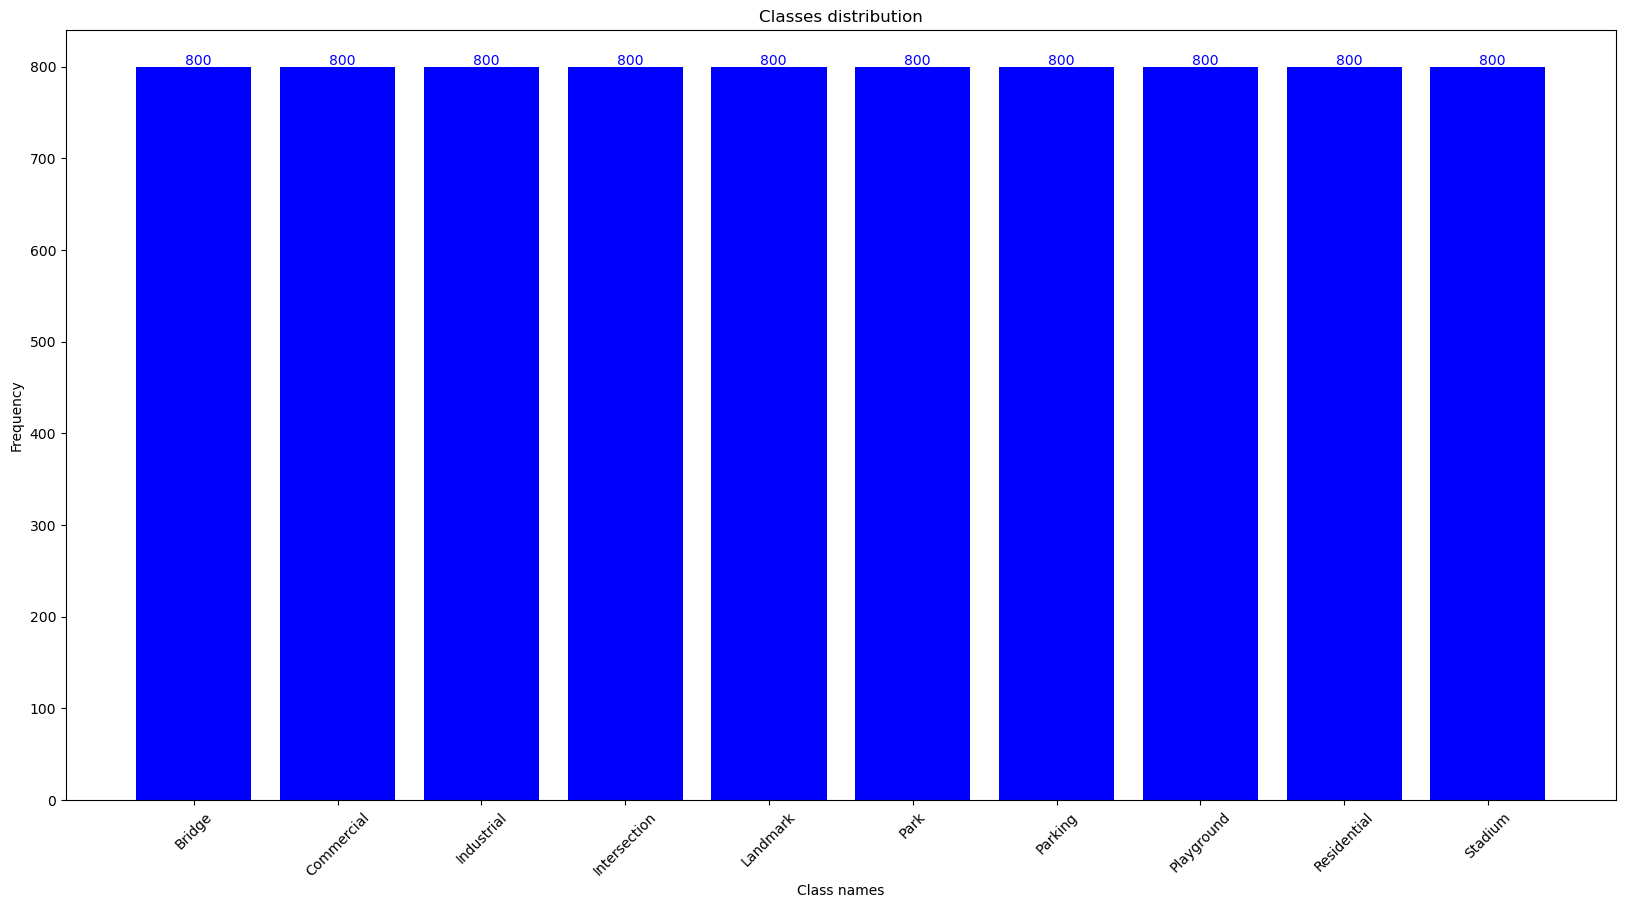

In [10]:
class_distribution(ds_path, transformations=transforms)

Classes are balanced across the dataset. This is good, however in order to mantain class proportions we craeted a stratified dataloaders, which take into consideration the proportios per class and mantains the same proportions for the train, val and test dataloaders.

## Model import and training using PyTorch and evaluating using TensorBoard

In [ ]:
#pip install tensorboard

### Defining imports, experiment params and utils function 

In [16]:
import timm
import torch.amp
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score 
from torchvision.utils import make_grid #For image visualization in TensorBoard
from torch.amp import GradScaler

#Change this number when doing an experiment forward 
experiment = 7

#Initialize TensorBoard
writer = SummaryWriter(f"logs/experiment{experiment}") #Folder where to save logs

#Ditionary to track hyperparameters
hyperparams = {
    "lr": 1e-4,
    "bs": 32, #In this case, the dataloaders are created in the cells above. We have to change it manually.
    "epochs": 10,
    "optimizer": "Adam", #This is only a text, to change it, go to "setup_train" and change it manually
    "precision FP16": True,
    "stratification": True
}
#Save the hyperparameters in a text for the current experiment
formatted_text = "\n".join([f"{key}: {value}" for key, value in hyperparams.items()])
writer.add_text("Hyperparameters", formatted_text)
#Import pretrained model
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=len(classes))

#Create the training setup for our transfer learning
def setup_train(model):
    """Easy way to create a setup environment given a model"""
    return model.to("cuda").train(), hyperparams["epochs"], "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params=model.parameters(), lr=hyperparams["lr"])
    #Put the model in train() behaviour
    #7hyperparams["epochs"] --> epochs
    #"cuda" --> str pointing to cuda device
    #CrossEntropy as the loss function
    #Adam as the optimizer with its parameters

#Function to move the data to the specified device
def move2device(batch, device):
    """Little function to move batches from CPU to GPU for calcs"""
    return batch[0].to(device), batch[1].to(device)

def calculate_losses(model, images, labels, loss_fn, epoch_loss, epoch_acc):
    """Calculate the losses and keep track of them per epoch"""
    #Generate predictions
    preds = model(images)
    #Calculate loss
    loss = loss_fn(preds, labels)
    #Updates the total loss and the accumulated accuracy
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == labels).sum().item()

# def calculate_PR(preds, labels):
#     """Function to track precision and recall for validation batches"""
#     preds_classes = torch.argmax(preds, dim=1).cpu().numpy()
#     true_labels = labels.cpu().numpy()
#     precision = precision_score(true_labels, preds_classes, average="weighted")
#     recall = recall_score(true_labels, preds_classes, average="weighted")
#     return precision, recall



### Training and eval cycle

In [17]:
##Training cycle
#Define the setup features
model, epochs, device, loss_fn, optimizer = setup_train(model)
#Create the GradScaler object for FP16 mixup precision
scaler = GradScaler() #Scaler for FP16
best_loss = float("inf")

for epoch in range(epochs):
    epoch_loss, epoch_acc = 0, 0
    model.train() #Put the model into training state
    for i, batch in tqdm(enumerate(tr_dl), total=len(tr_dl)):
        imgs, lbls = move2device(batch, device)
        #Activate autocast for mixed precision
        with torch.amp.autocast(device):
            loss, epoch_loss, epoch_acc = calculate_losses(model, imgs, lbls, loss_fn, epoch_loss, epoch_acc)
            #Put the grads to 0
            optimizer.zero_grad()
            #Calculate grads
            scaler.scale(loss).backward()
            #Optimizer do an step using those grads
            scaler.step(optimizer)
            #Update dynamic scaler
            scaler.update()
        
    #Register training metrics into TensorBoard
    #Mean loss per training batch
    tr_loss_to_track = epoch_loss / len(tr_dl)
    #Mean acc. per epoch
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    writer.add_scalar("Loss/Train", tr_loss_to_track, epoch)
    writer.add_scalar("Accuracy/Train", tr_acc_to_track, epoch)

    print(f"TRAINING: {epoch + 1}-epoch train loss: {tr_loss_to_track:.3f}, train accuracy: {tr_acc_to_track:.3f}")


#Validation cycle
    val_epoch_loss, val_epoch_acc = 0, 0
    val_epoch_precision, val_epoch_recall = 0, 0
    all_preds, all_labels = [], []
    model.eval()
    #During evaluation we do not calculate gradients
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dl), total=len(val_dl)):
            imgs, lbls = move2device(batch, device)
            #Activate autocast for validation (FP16)
            with torch.amp.autocast(device):
                preds = model(imgs)
                loss = loss_fn(preds, lbls)

            val_epoch_loss += loss.item()
            #From preds (for each image has a tensor of 10 logits), get the total of corrects predictions
            val_epoch_acc += (torch.argmax(preds, dim=1) == lbls).sum().item()
            #Accumulation of preds and labels, to calculate at the end of the val.
            #Calculating precisio and recall per batch could cause problems as there could be batches without
            #certain type of images.
            all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
            
            #Save images from the first batch only, as samples
            if i == 0:
                grid = make_grid(imgs[0:8].cpu(), nrow=2, normalize=True)
                writer.add_image(f"Validation examples/Epoch {epoch+1}", grid, epoch)
                writer.add_text(f"Predictions/Epoch {epoch+1}",
                                f"Predicted: {torch.argmax(preds[:8], dim=1).cpu().numpy()}, "
                                f"Actual: {lbls[:8].cpu().numpy(), epoch}", 
                                epoch + 1
                                )

    #Register training metrics into TensorBoard
    #Mean loss per batch
    val_loss_to_track = val_epoch_loss / len(val_dl) # len(val_dl) is the total number of batches
    #Mean accuracy of the val dataset
    val_acc_to_track = val_epoch_acc / len(val_dl.dataset) #The reason we use dataset is because it is calculated per image
    #Mean precision and recall using all preds and labels from the validation cycle.
    val_precision_to_track = precision_score(all_preds, all_labels, average="weighted")
    val_recall_to_track = recall_score(all_preds, all_labels, average="weighted")
    #Write and register the metrics
    writer.add_scalar("Loss/Validation", val_loss_to_track, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc_to_track, epoch)
    writer.add_scalar("Precision/Validation", val_precision_to_track, epoch)
    writer.add_scalar("Recall/Validation", val_recall_to_track, epoch)


    #Save the best model
    if val_loss_to_track < best_loss:
        os.makedirs("saved_models", exist_ok=True)
        best_loss = val_loss_to_track
        torch.save(model.state_dict(), f"saved_models/best_model_{experiment}.pth")
        print(f"Current best weights in this epoch ({epoch+1}), saving them...")
    
writer.close()


  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 1-epoch train loss: 0.406, train accuracy: 0.863


  0%|          | 0/13 [00:00<?, ?it/s]

Current best weights in this epoch (1), saving them...


  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 2-epoch train loss: 0.102, train accuracy: 0.964


  0%|          | 0/13 [00:00<?, ?it/s]

Current best weights in this epoch (2), saving them...


  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 3-epoch train loss: 0.047, train accuracy: 0.983


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 4-epoch train loss: 0.037, train accuracy: 0.989


  0%|          | 0/13 [00:00<?, ?it/s]

Current best weights in this epoch (4), saving them...


  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 5-epoch train loss: 0.036, train accuracy: 0.989


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 6-epoch train loss: 0.047, train accuracy: 0.986


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 7-epoch train loss: 0.026, train accuracy: 0.992


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 8-epoch train loss: 0.030, train accuracy: 0.991


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 9-epoch train loss: 0.026, train accuracy: 0.992


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

TRAINING: 10-epoch train loss: 0.025, train accuracy: 0.992


  0%|          | 0/13 [00:00<?, ?it/s]

## Inferencing witht our model: results

In [18]:
import random

def visualize_inference(model, device, test_dl: Dataset, num_images, rows, class_names=None):
    """
    Visualize predictions and true labels in a grid with correct/incorrect colors 
    """
    #Set model to evaluation
    model.eval()
    model.to(device)
    #Calculate num columns and round up
    cols = (num_images + rows - 1) // rows 

    imgs, lbls, preds = [], [], []
    correct = 0
    #Remember that our test_dl has a batch size of 1
    for batch in test_dl:       
        #Get img and lbl and move to device
        img, lbl = move2device(batch, device)
        #Forward pass
        result = model(img) 
        #Get prediction
        pred = torch.argmax(result, dim=1)
        #Calculate if pred is correct and transform into a number (not a bool tensor!)
        correct += (pred == lbl).sum().item()

        #Store data for visualization, only until num_images
        if len(imgs) <= num_images:
            imgs.extend(img.cpu())
            lbls.extend(lbl.cpu().numpy())
            preds.extend(pred.cpu().numpy())
        
    #Calculate accuracy
    accuracy = (correct / len(test_dl.dataset)) * 100
    
    #Pot images using a grid
    fig, axes = pt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten() #Flatten for an easy iteration
    # Title of the figure is the accuracy
    fig.suptitle(f"Test Dataset Accuracy: {accuracy:.2f}%", fontsize=18, color="black")
    fig.subplots_adjust(top=0.2)

    for idx, ax in enumerate(axes):
        if idx < len(imgs):
            #Get image, label and pred
            image = tensor2image(imgs[idx])
            label = lbls[idx]
            prediction = preds[idx]

            #Display the image
            ax.imshow(image)
            ax.axis("off")

            #Set titles
            color = "green" if label == prediction else "red"
            ax.set_title(f"True L: {class_names[label]}\nPred: {class_names[prediction]}", color=color)
        else: #Important, turn extra axes off if fewer images than grid space
            ax.axis("off")
            
    pt.tight_layout()
    pt.show()

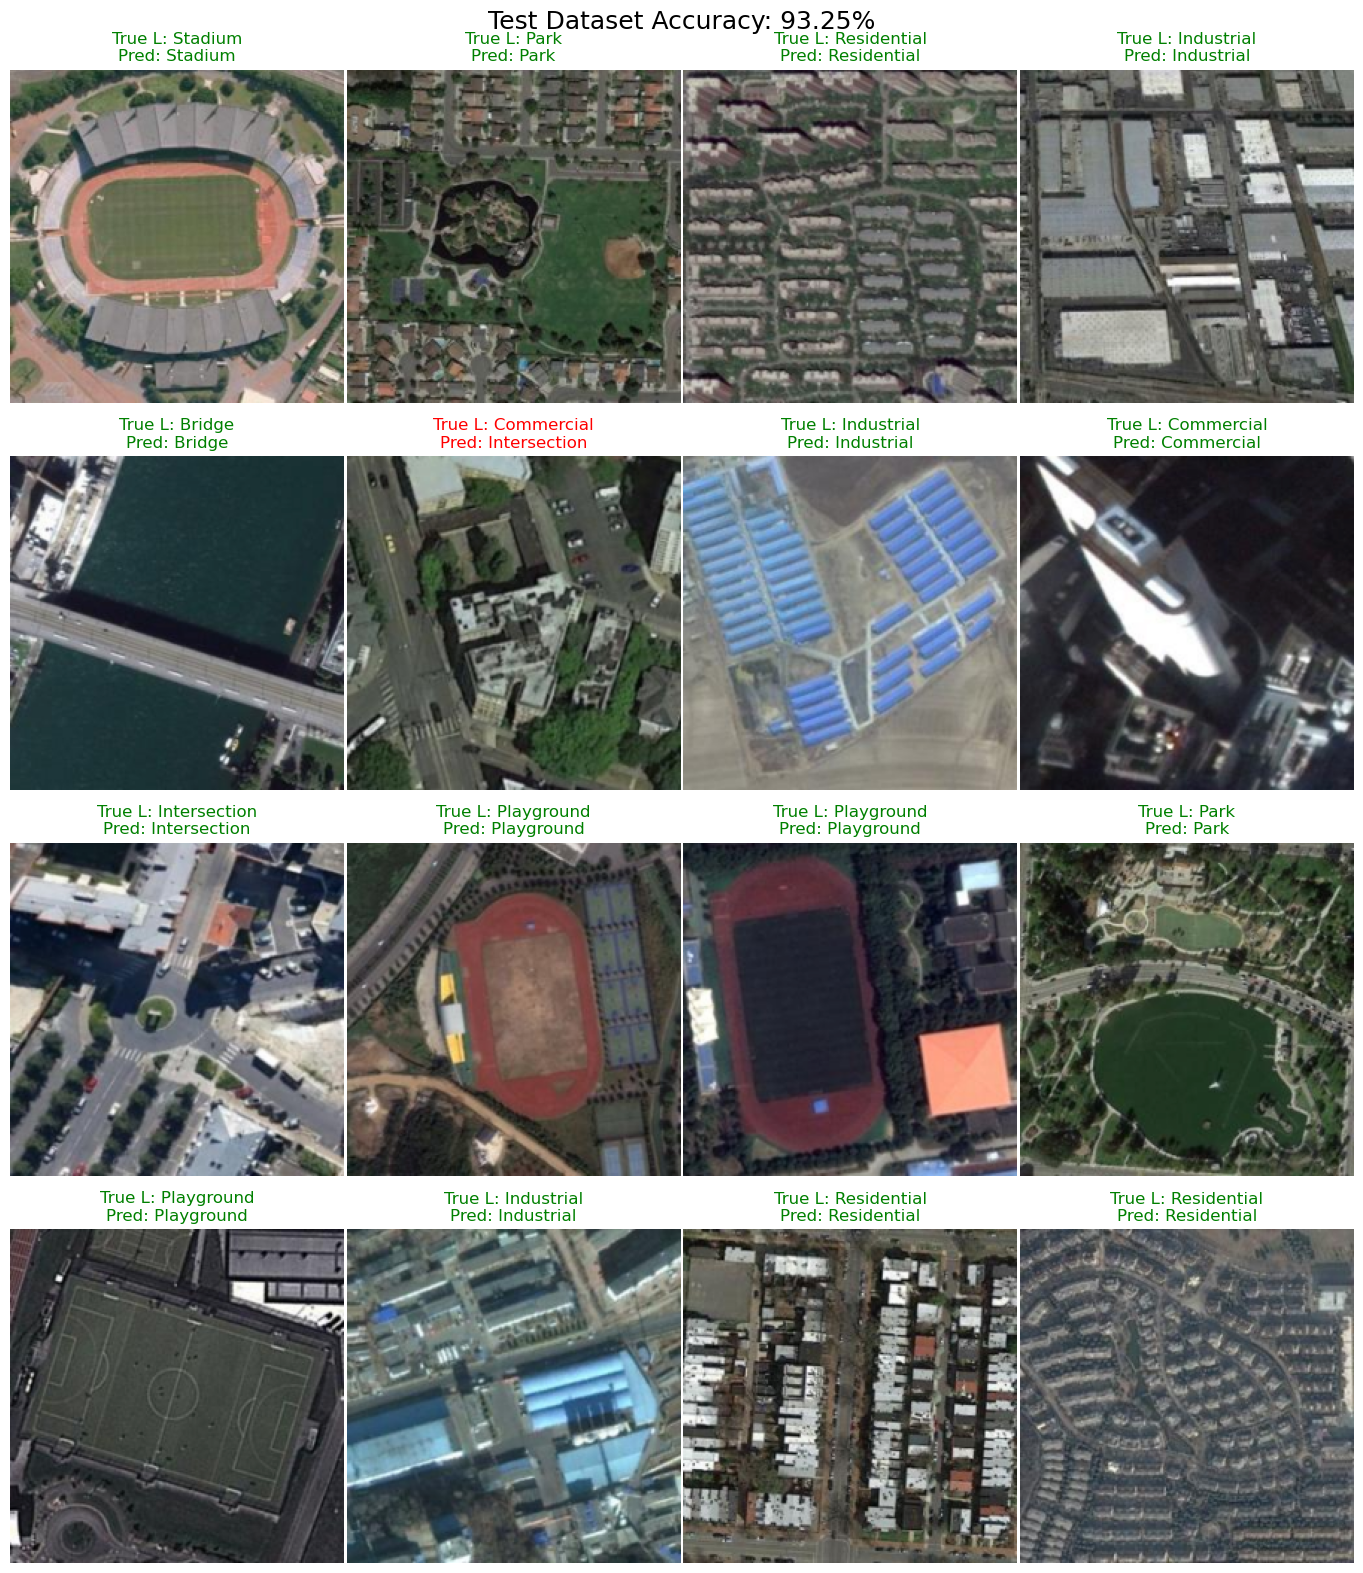

In [20]:
visualize_inference(model=model,
                    device="cuda",
                    test_dl=test_dl,
                    num_images=16,
                    rows=4,
                    class_names=list(classes.keys())
                    )

In [ ]:
#Copied CODE
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix

class SaveFeatures():
    
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    
    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        # if idx == 20: break
        im, gt = move2device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    
    pt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Start plot
        pt.subplot(row, num_ims // row, idx + 1)
        pt.imshow(tensor2image(im), cmap = "gray"); pt.axis("off")
        #pt.imshow(cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); pt.axis("off")
        
        if cls_names is not None: pt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: pt.title(f"GT -> {gt} ; PRED -> {pred}")
    
    pt.figure(figsize = (20, 10))
    sns.heatmap(confusion_matrix(preds, lbls), annot=True, fmt='d', xticklabels=cls_names, yticklabels=cls_names)
    pt.title("Confusion Matrix")

#Inference for dataloaders with more than 1 image

def inference_big(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names=None):
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []

    for idx, batch in tqdm(enumerate(test_dl)):
        # Mover las imágenes y etiquetas al dispositivo
        im, gt = move2device(batch, device)  # Batch completo
        
        # Forward pass
        result = model(im)  # Salida para todo el batch

        # Obtener predicciones
        pred_class = torch.argmax(result, dim=1)  # Tensor de predicciones para el batch

        # Calcular precisión
        acc += (pred_class == gt).sum().item()  # Contar predicciones correctas en el batch

        # Almacenar datos para visualización
        images.extend(im.cpu())  # Todas las imágenes del batch
        preds.extend(pred_class.cpu().numpy())  # Predicciones como NumPy array
        lbls.extend(gt.cpu().numpy())  # Etiquetas verdaderas como NumPy array

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    # Visualización de las imágenes
    pt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Dibujar
        pt.subplot(row, num_ims // row, idx + 1)
        pt.imshow(tensor2image(im), cmap="gray")
        pt.axis("off")
        if cls_names is not None:
            pt.title(
                f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}",
                color=("green" if cls_names[int(lbls[indeks])] == cls_names[int(preds[indeks])] else "red")
            )

    # Visualización de la matriz de confusión
    pt.figure(figsize=(20, 10))
    sns.heatmap(confusion_matrix(preds, lbls), annot=True, fmt='d', xticklabels=cls_names, yticklabels=cls_names)
    pt.title("Confusion Matrix")



model.load_state_dict(torch.load("saved_models/best_model_5.pth"))
model.eval()
final_conv, fc_params = model.stages[-1].blocks[-1], list(model.head.fc.parameters())
inference_big(model = model.to(device), device = device, test_dl = val_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)

## Integrating Captum and LayerGradCAM for inference and visualization

### Load model and configure Captum

In [ ]:
from captum.attr import LayerGradCam

#Load model
model = timm.create_model("convnext_tiny", pretrained=False, num_classes=len(classes))

#Load weights into the model
model.load_state_dict(torch.load("saved_models/best_model_5.pth"))
model.eval() #Put the model in eval mode

#Selec the target layer for the GradCAM (these are 2 ways, i am experimenting with them)
target_layer = model.stages[-1].blocks[-1]#.conv_dw
another_way_to_target_layer = list(model.children())[-3]

### Get the first image of the test_dl

In [ ]:
#test_dl is a dynamic iterator, we need to simulate 1 iter to get a batch
test_batch = next(iter(test_dl))
test_batch = next(iter(test_dl))
#A batch is composed by (img, lbl). Remember that test_dl are batches of 1 img!
test_images,test_labels = test_batch
#Get the first image of the batch and its label. In this case the batch is 1 image and 1 label
#However if the batch had more, we need to pick one using indexing []
first_image = test_images #[0].unsqueeze(0) #We add batch dimension because "attributions" expects it
first_label = test_labels[0] #[0]

### Create GradeCAM object, extract attributes from the target layer, upsample, process and display

In [ ]:
import cv2

def visualize_gradcam(model, layer, input_tensor, target_class):
    """Pass an image (as transformed tensor) and its label to get the its GradCAM and plot it blended"""
    #Create GradCAM object extractor with LayeredGradCam, model and target layer
    gradcam = LayerGradCam(model, layer)
    #Get the attributes of the image according to the target class
    attr = gradcam.attribute(input_tensor, target=target_class)
    #Detach, move to cpu and transform to numpy
    heatmap = attr.squeeze().cpu().detach().numpy()
    #In the ConvNext, the target layer produces a 7x7 map. We need to make it bigger to place over the org iamge
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    #Normalize the heatmap values. +1e-8 is to avoid div by 0 in case all pixels are equals.
    heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized) + 1e-8)
  
    #Visualization using matplotlib
    fig, ax = pt.subplots(figsize=(6, 6))  # Create figures and axes
    ax.imshow(tensor2image(input_tensor))  # Show original image (inverted transformed!)
    heatmap_img = ax.imshow(heatmap_resized, cmap="viridis", alpha=0.4)  # Place the heatmap over
    
    #Add color bar to identify positive and negative zones
    cbar = fig.colorbar(heatmap_img, ax=ax, fraction=0.03, pad=0.05)  # Creates color bar
    cbar.set_label("Importance", rotation=270, labelpad=15)  # Title of the bar
    
    #Title and set axis to hidden
    pt.title(f"GradCAM for class {target_class}")
    pt.axis("off")
    pt.show()

In [ ]:
visualize_gradcam(model, target_layer, first_image, first_label)

Now that we have a function to show GradCAM, we can create a GradCAM for each class using a true image, to see if what the model is "seeing" is revelant to our needs.

In [ ]:
test_images_folder = "test_images_GradCAM"
# Creates a dict with name of image as key and class as value, using the "classes" var from our dataloaders output
images_files = {f: classes[f.split(".")[0].capitalize()] for f in os.listdir(test_images_folder) if f.endswith(".jpg")}

for img, cls in images_files.items():
    #Get the image as PIL
    image = Image.open(os.path.join(test_images_folder,img)).convert("RGB")
    #Transform and add dummy batch to image
    trf_image = transforms(image).unsqueeze(0)
    #Print the class as name
    print("Class: " + img.split(".")[0].capitalize())
    #Invoke the function to show the GradCAM
    visualize_gradcam(model, target_layer, trf_image, cls)


Awesome! Our model is working quite good, as we can see:
- For parking, is focusing where the vehicles are
- For intersection, looks exactly at the intersection

...

- For playgroud, is focusing on the field of the playground

and so...

Therefor the model is working well, and the interpretation that is doing from our input images seems correct.

## Feature attribution using Captum

Imagine you have a model that takes an image as input and gives you a prediction—a confidence score for each possible category. Feature attribution is about figuring out which parts of the image (which pixels or regions) were most important for that particular prediction. Let's do a simple feature attribution using `IntegratedGradients`

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
#Initialization of the attribute algorithm
integrated_gradients = IntegratedGradients(model)

#Get the attributions of our output
attributions_image = integrated_gradients.attribute(first_image, target=first_label, n_steps=100)

#Show the original image for comparison
_ = viz.visualize_image_attr(None, 
                             tensor2image(first_image),
                             method="original_image", title="Original Image"
                             )

default_cmap = LinearSegmentedColormap.from_list("custom blue",
                                                 [(0, "#ffffff"),
                                                  (0.25, "#0000ff"),
                                                  (1, "#0000ff")], N=256)

#Show the overlaping map with the original image
_ = viz.visualize_image_attr(np.transpose(attributions_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             tensor2image(first_image),
                             method="blended_heat_map",
                             cmap="viridis",
                             show_colorbar=True,
                             sign="positive",
                             title="Integrated Gradients")

This show how each pixel of the input image is "weighted" on the output, giving more or less importance